In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

Circuit QFT8_before on 8 qubits with 148 gates.
        84 T-like gates
        64 Cliffords among which 
        56 2-qubit gates and 8 Hadamard gates.


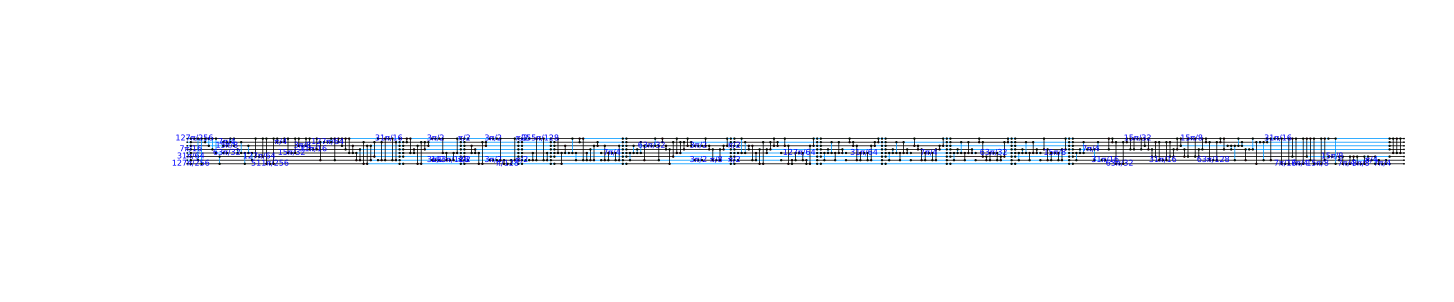

In [209]:
circ_name = r'..\circuits\QFT_and_Adders\QFT8_before'
c = zx.Circuit.load(circ_name).to_basic_gates()
print(c.stats())
g = c.to_graph()
zx.simplify.full_reduce(g)
circuit = zx.extract.streaming_extract(g)
circuit.gates
zx.draw(circuit, figsize=(20,4))

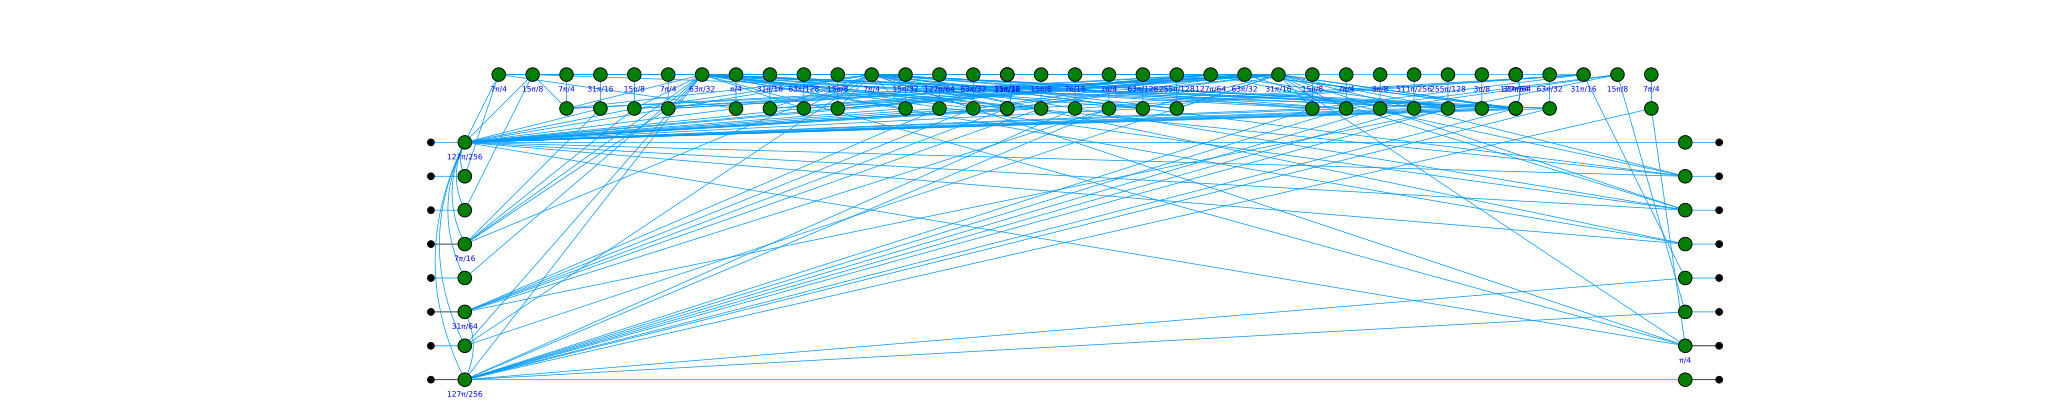

In [56]:
g.normalise()
zx.draw(g, figsize=(30,6))

In [210]:
c2, blocks = circuit_phase_polynomial_blocks(c.to_basic_gates(),optimize=True)
print(c2.stats())

Circuit  on 8 qubits with 106 gates.
        42 T-like gates
        64 Cliffords among which 
        56 2-qubit gates and 8 Hadamard gates.


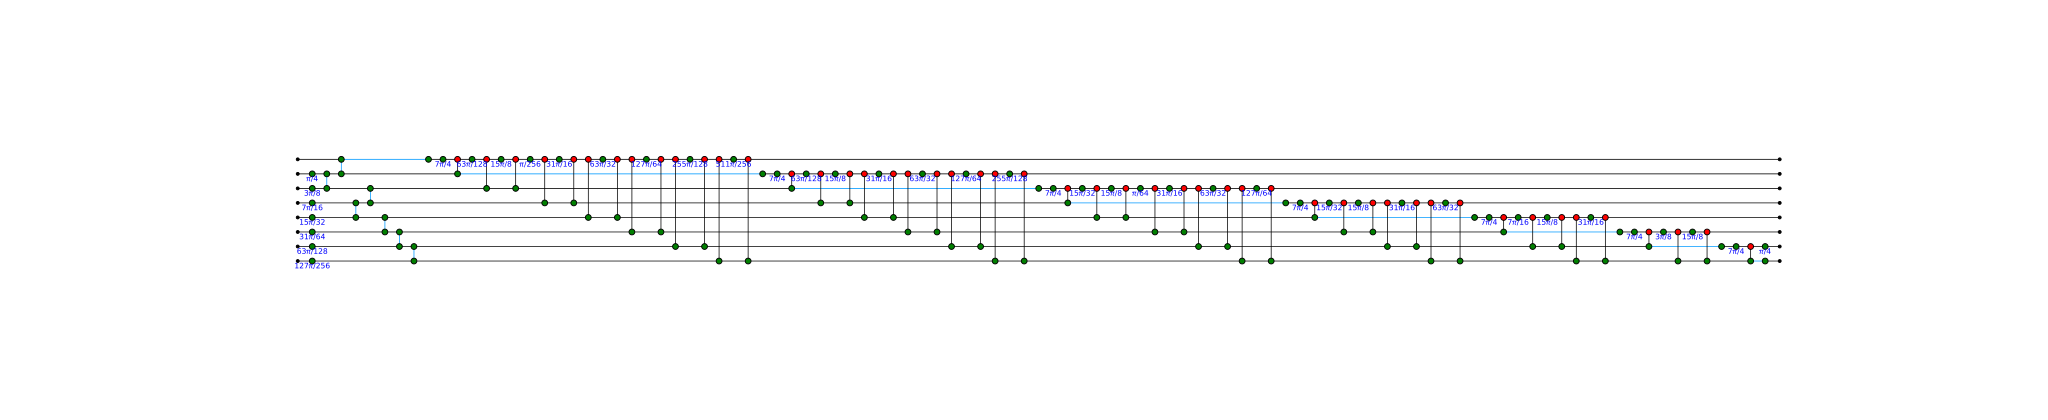

In [51]:
zx.draw(c2, figsize=(30,6))

Circuit  on 8 qubits with 257 gates.
        42 T-like gates
        215 Cliffords among which 
        176 2-qubit gates and 22 Hadamard gates.


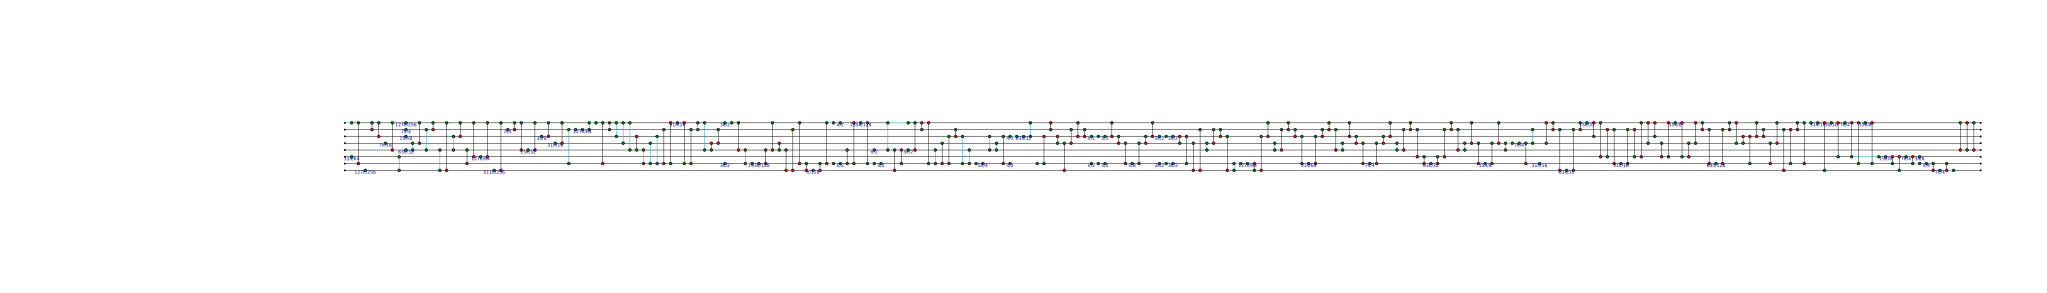

In [211]:
o = Optimizer(circuit.to_basic_gates())
c = o.parse_circuit()
print(c.stats())
zx.draw(c, figsize=(50,7))

In [43]:
for i in range(8):
    c3, blocks = circuit_phase_polynomial_blocks(c,optimize=True)
    print(c3.stats())
    o = Optimizer(c3)
    c = o.parse_circuit()
    print(c.stats())
# print(c4.stats())
# c5, blocks = circuit_phase_polynomial_blocks(c4,optimize=True)
# print(c5.stats())
# o = Optimizer(c5)
# c6 = o.parse_circuit()
# print(c6.stats())

Circuit  on 8 qubits with 283 gates.
        42 T-like gates
        241 Cliffords among which 
        157 2-qubit gates and 72 Hadamard gates.
Circuit  on 8 qubits with 233 gates.
        42 T-like gates
        191 Cliffords among which 
        159 2-qubit gates and 20 Hadamard gates.
Circuit  on 8 qubits with 275 gates.
        42 T-like gates
        233 Cliffords among which 
        151 2-qubit gates and 68 Hadamard gates.
Circuit  on 8 qubits with 229 gates.
        42 T-like gates
        187 Cliffords among which 
        153 2-qubit gates and 20 Hadamard gates.
Circuit  on 8 qubits with 277 gates.
        42 T-like gates
        235 Cliffords among which 
        152 2-qubit gates and 70 Hadamard gates.
Circuit  on 8 qubits with 227 gates.
        42 T-like gates
        185 Cliffords among which 
        152 2-qubit gates and 20 Hadamard gates.
Circuit  on 8 qubits with 277 gates.
        42 T-like gates
        235 Cliffords among which 
        152 2-qubit gates and 70 H

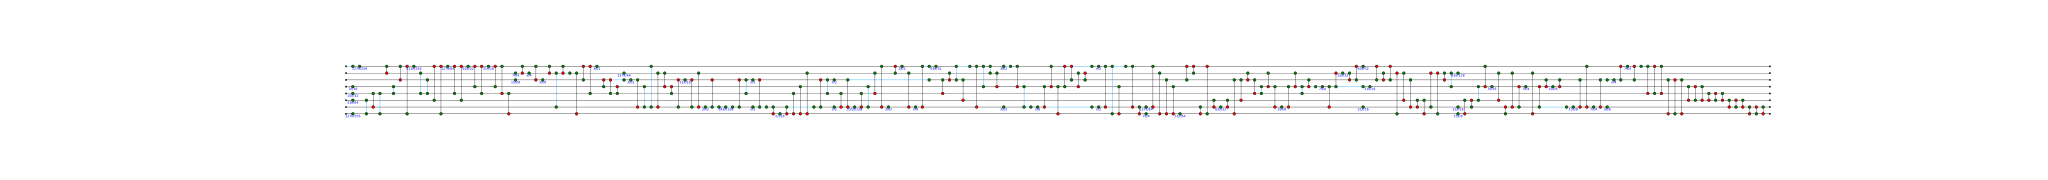

In [45]:
zx.draw(c, figsize=(70,6))

In [212]:
zx.compare_tensors(c, circuit)

False

In [246]:
from pyzx.circuit import Circuit, ZPhase, CNOT, CZ, Z, ParityPhase, NOT, HAD, SWAP, S
from pyzx.extract import permutation_as_swaps

def toggle_element(l, e):
    if e in l: l.remove(e)
    else: l.append(e)

def swap_element(l, e1, e2):
    if e1 in l and e2 not in l:
        l.remove(e1)
        l.append(e2)
    elif e2 in l and e1 not in l:
        l.remove(e2)
        l.append(e1)

def stats(circ):
    two_qubit = 0
    had = 0
    non_pauli = 0
    for g in circ.gates:
        if g.name in ('CZ', 'CNOT'):
            two_qubit += 1
        elif g.name == 'HAD':
            had += 1
        elif g.name != 'NOT' and g.phase != 1:
            non_pauli += 1
    return had, two_qubit, non_pauli

class Optimizer:
    def __init__(self, circuit):
        self.circuit = circuit
        self.qubits = circuit.qubits
        self.minimize_czs = False
    
    def parse_circuit(self, max_iterations=1000):
        self.minimize_czs = False
        self.circuit = self.parse_forward()
        count = stats(self.circuit)
        i = 0
        while True:
            self.circuit.gates = list(reversed(self.circuit.gates))
            self.circuit = self.parse_forward()
            self.circuit.gates = list(reversed(self.circuit.gates))
            self.circuit = self.parse_forward()
            i += 1
            s = stats(self.circuit)
            if self.minimize_czs and (all(s1<=s2 for s1,s2 in zip(count,s)) or i>=max_iterations): break
            count = s
            self.minimize_czs = True
        for g in self.circuit.gates: g.index = 0
        return self.circuit
    
    def parse_forward(self):
        self.gates = {i:list() for i in range(self.qubits)}
        self.available = {i:list() for i in range(self.qubits)}
        self.availty = {i: 1 for i in range(self.qubits)}
        self.hadamards = []
        self.nots = []
        self.zs = []
        self.permutation = {i:i for i in range(self.qubits)}
        self.gcount = 0
        for g in self.circuit.gates:
            self.parse_gate(g)
            #if any(gs!=list(sorted(gs,key=lambda g: g.index)) for gs in self.gates.values()):
            #    print("Errawrrr")
            #    for gs in self.gates.values():
            #        print([g.index for g in gs])
        for t in self.hadamards.copy():
            self.add_hadamard(t)
        for t in self.zs:
            z = Z(t)
            z.index = self.gcount
            self.gcount += 1
            self.gates[t].append(z)
        for t in self.nots:
            n = NOT(t)
            n.index = self.gcount
            self.gcount += 1
            self.gates[t].append(n)
        
        c = Circuit(self.qubits)
        #indices = []
        for gs in self.gates.values():
            for g in gs:
                if g not in c.gates:
                    c.gates.append(g)
#                 if g.index not in indices:
#                     indices.append(g.index)
#                     c.gates.append(g)
        c.gates.sort(key = lambda g: g.index)
        swaps = permutation_as_swaps(self.permutation)
        for a,b in swaps:
            c.gates.extend(SWAP(a,b).to_basic_gates())
        return c
    
    def add_hadamard(self, t):
        h = HAD(t)
        h.index = self.gcount
        self.gates[t].append(h)
        self.gcount += 1
        self.hadamards.remove(t)
        self.available[t] = list()
        self.availty[t] = 1
    
    def add_gate(self, t, g):
        g.index = self.gcount
        self.gcount += 1
        self.gates[t].append(g)
        self.available[t].append(g)
    
    def add_cz(self, cz):
        t1, t2 = cz.control, cz.target
        #We first try to find a matching CNOT gate
        found_match = False
        if self.minimize_czs:
            for c,t in [(t1,t2),(t2,t1)]:
                for g in self.available[c]:
                    if g.name == 'CNOT' and g.control == c and g.target == t:
                        if self.availty[t] == 2:
                            if g in self.available[t]:
                                found_match = True
                                break
                            else:
                                continue
                        for h in list(reversed(self.gates[t][:-len(self.available[t])])):
                            if h == g:
                                found_match = True
                                break
                            if h.name != 'CNOT' or h.target != t:
                                break
                        if found_match: break
                if found_match: break
        if found_match: #CNOT-CZ = (S* x id)CNOT (S x S)
            #print("Match!")
            #print(cz, g)
            t,c = g.target, g.control
            #print(self.available[t], self.available[c])
            #print(self.gates[t], self.gates[c])
            if self.availty[t] == 2:
                self.availty[t] == 1
                self.available[t] = []
            self.gates[t].remove(g)
            self.gates[c].remove(g)
            self.available[c].remove(g)
            s1 = S(t, adjoint=True)
            if self.available[t]:
                s1.index = self.available[t][0].index-0.3
                g.index = self.available[t][0].index-0.2
                self.gates[t].insert(-len(self.available[t]),s1)
                self.gates[t].insert(-len(self.available[t]),g)
            else: 
                s1.index = self.gcount
                self.gcount += 1
                self.gates[t].append(s1)
                g.index = self.gcount
                self.gcount += 1
                self.gates[t].append(g)
            s2 = S(t)
            s2.index = self.gcount
            self.gcount += 1
            self.gates[t].append(s2)
            self.available[t].append(s2)
            s3 = S(c)
            s3.index = self.gcount
            self.gcount += 1
            self.available[c].append(g)
            self.available[c].append(s3)
            self.gates[c].append(g)
            self.gates[c].append(s3)
            #print(self.available[t], self.available[c])
            #print(self.gates[t], self.gates[c])
            #print([g.index for g in self.gates[t]], [g.index for g in self.gates[c]])
            return
        if self.availty[t1] == 2:
            self.available[t1] = list()
            self.availty[t1] = 1
        if self.availty[t2] == 2:
            self.available[t2] = list()
            self.availty[t2] = 1
        found_match = False
        for g in reversed(self.available[t1]):
            if g.name == 'CZ' and g.control == t1 and g.target == t2:
                found_match = True
                break
        if found_match:
            if g not in self.available[t2]:
                found_match = False
            else:
                self.available[t1].remove(g)
                self.gates[t1].remove(g)
                self.available[t2].remove(g)
                self.gates[t2].remove(g)
                #self.detect_available(t1)
                #self.detect_available(t2)
        if not found_match:
            cz.index = self.gcount
            self.gcount += 1
            self.gates[t1].append(cz)
            self.gates[t2].append(cz)
            self.available[t1].append(cz)
            self.available[t2].append(cz)
    
    def add_cnot(self, cnot):
        c, t = cnot.control, cnot.target
        if self.availty[c] == 2:
            if self.availty[t] == 1: # Try to find anti-match
                found_match = False
                for g in reversed(self.available[c]):
                    if g.name == 'CNOT' and g.control == t and g.target == c:
                        found_match = True
                        break
                if found_match: # We're adding a swap gate
                    #print("swap gate boom")
                    if g in self.available[t]:
                        self.gates[c].remove(g)
                        self.gates[t].remove(g)
                        self.availty[c] = 1
                        self.availty[t] = 2
                        cnot.index = self.gcount
                        self.gcount += 1
                        self.gates[c].append(cnot)
                        self.gates[t].append(cnot)
                        self.available[c] = [cnot]
                        self.available[t] = [cnot]
                        a = self.permutation[c]
                        b = self.permutation[t]
                        self.permutation[c] = b
                        self.permutation[t] = a
                        swap_element(self.hadamards, t, c)
                        swap_element(self.nots, t, c)
                        swap_element(self.zs, t, c)
                        return
                
            self.available[c] = list()
            self.availty[c] = 1
        if self.availty[t] == 1:
            self.available[t] = list()
            self.availty[t] = 2
        found_match = False
        for g in reversed(self.available[c]):
            if g.name == 'CNOT' and g.control == c and g.target == t:
                found_match = True
                break
        if found_match:
            if g not in self.available[t]:
                found_match = False
            else:
                self.available[c].remove(g)
                self.gates[c].remove(g)
                self.available[t].remove(g)
                self.gates[t].remove(g)
                self.detect_available(c)
                self.detect_available(t)
                
        if not found_match:
            cnot.index = self.gcount
            self.gcount += 1
            self.gates[c].append(cnot)
            self.gates[t].append(cnot)
            self.available[c].append(cnot)
            self.available[t].append(cnot)
    
    def detect_available(self, t):
        pass
    
    def parse_gate(self, g):
        g = g.copy()
        g.target = next(i for i in self.permutation if self.permutation[i] == g.target)
        t = g.target
        if g.name in ('CZ', 'CNOT'):
            g.control = next(i for i in self.permutation if self.permutation[i] == g.control)
        if g.name == 'HAD':
            if t in self.nots and t not in self.zs:
                self.nots.remove(t)
                self.zs.append(t)
            elif t in self.zs and t not in self.nots:
                self.zs.remove(t)
                self.nots.append(t)
            if len(self.gates[t])>1 and self.gates[t][-2].name == 'HAD' and isinstance(self.gates[t][-1], ZPhase):
                    g2 = self.gates[t][-1]
                    if g2.phase.denominator == 2:
                        h = self.gates[t][-2]
                        zp = ZPhase(t, (-g2.phase)%2)
                        zp.index = h.index-0.5
                        self.gcount += 1
                        g2.phase = zp.phase
                        self.gates[t].insert(-2,zp)
                        return
            toggle_element(self.hadamards, t)
        elif g.name == 'NOT':
            toggle_element(self.nots, t)
        elif isinstance(g, ZPhase):
            if t in self.zs:
                g.phase = (g.phase+1)%2
                self.zs.remove(t)
            if g.phase == 0: return
            if t in self.nots:
                g.phase = (-g.phase)%2
            if g.phase == 1:
                toggle_element(self.zs, t)
                return
            if t in self.hadamards:
                self.add_hadamard(t)
            if self.availty[t] == 1 and any(isinstance(g2, ZPhase) for g2 in self.available[t]):
                i = next(i for i,g2 in enumerate(self.available[t]) if isinstance(g2, ZPhase))
                g2 = self.available[t].pop(i)
                self.gates[t].remove(g2)
                phase = (g.phase+g2.phase)%2
                if phase == 1:
                    toggle_element(self.zs, t)
                    return
                if phase != 0:
                    p = ZPhase(t, phase)
                    self.add_gate(t,p)
            else:
                if self.availty[t] == 2:
                    self.availty[t] = 1
                    self.available[t] = list()
                self.add_gate(t, g)
        elif g.name == 'CZ':
            t1, t2 = g.control, g.target
            if t1 > t2:
                g.target = t1
                g.control = t2
            if t1 in self.nots:
                toggle_element(self.zs, t2)
            if t2 in self.nots:
                toggle_element(self.zs, t1)
            if t1 in self.hadamards and t2 in self.hadamards:
                self.add_hadamard(t1)
                self.add_hadamard(t2)
            if t1 not in self.hadamards and t2 not in self.hadamards:
                self.add_cz(g)
            # Exactly one of t1 and t2 has a hadamard
            elif t1 in self.hadamards:
                cnot = CNOT(t2, t1)
                self.add_cnot(cnot)
            else:
                cnot = CNOT(t1, t2)
                self.add_cnot(cnot)
            
        elif g.name == 'CNOT':
            c, t = g.control, g.target
            if c in self.nots:
                toggle_element(self.nots, t)
            if t in self.zs:
                toggle_element(self.zs, c)
            if c in self.hadamards and t in self.hadamards:
                g.control = t
                g.target = c
                self.add_cnot(g)
            elif c not in self.hadamards and t not in self.hadamards:
                self.add_cnot(g)
            elif t in self.hadamards:
                cz = CZ(c if c<t else t, c if c>t else t)
                self.add_cz(cz)
            else: # Only the control has a hadamard gate in front of it
                self.add_hadamard(c)
                self.add_cnot(g)
        
        else:
            raise TypeError("Unknown gate {}".format(str(g)))

In [152]:
a = [-3,-4,-5, 1, 2, 3]
a.insert(-3, 'a')
a.insert(-3, 'b')
a

[-3, -4, -5, 'a', 'b', 1, 2, 3]

succes!
True True


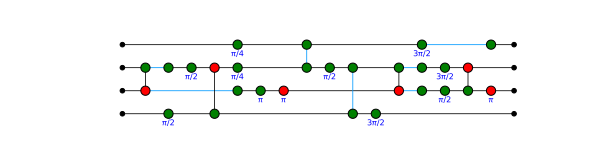

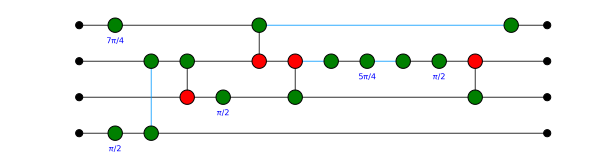

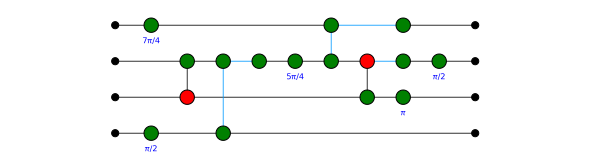

In [254]:
from pyzx.circuit import T
def generate_clifford():
    g = zx.generate.cliffords(4,9)
    zx.simplify.to_gh(g)
    return Optimizer(zx.Circuit.from_graph(g)).parse_circuit(1)

i = 0
while True:
    i += 1
    if i%50 == 0:
        print(i, end='.')
    c1 = generate_clifford()
    c2 = generate_clifford()
    c1.add_gate(T(0))
    c1.add_gate(T(1))
    c1.add_circuit(c2)
    g = c1.to_graph()
    zx.simplify.clifford_simp(g,quiet=True)
    c2 = zx.extract.streaming_extract(g)
    o = Optimizer(c2.to_basic_gates())
    c2 = o.parse_circuit()
    c3 = Optimizer(c1).parse_circuit()
    if not zx.compare_tensors(c1,c3):
        print("Errawr")
        break
    #c3 = Optimizer(c3).parse_circuit()
    c3, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
    c3 = Optimizer(c3).parse_circuit()
    if not zx.compare_tensors(c1,c3):
        print("Errawr2")
        break
    #c3 = Optimizer(c3).parse_circuit()
#     c3, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
#     c3 = Optimizer(c3).parse_circuit()
    two_qubit = sum(1 for g in c3.gates if g.name in ('CZ', 'CNOT'))
    if two_qubit < 6 and len(c2.gates) < len(c3.gates) and sum(1 for g in c2.gates if g.name in ('CZ', 'CNOT')) < two_qubit:
        print("succes!")
        break

print(zx.compare_tensors(c1,c2),zx.compare_tensors(c1,c3))
display(zx.draw(c1))
display(zx.draw(c3))
display(zx.draw(c2))

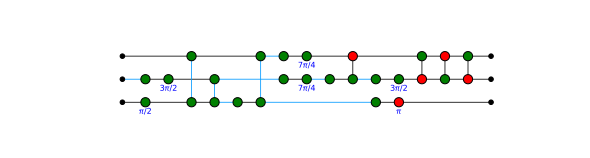

Match!
CZ(1,2) CNOT(1,2)
[CNOT(2,0)] [CNOT(1,2)]
[CNOT(1,2), CNOT(2,0)] [CNOT(0,1), ZPhase(1,phase=7/4), HAD(1), CNOT(1,2)]
[CNOT(2,0), S(2)] [CNOT(1,2), S(1)]
[S*(2), CNOT(1,2), CNOT(2,0), S(2)] [CNOT(0,1), ZPhase(1,phase=7/4), HAD(1), CNOT(1,2), S(1)]
[9.7, 9.8, 10, 11] [4, 5, 8, 9.8, 12]


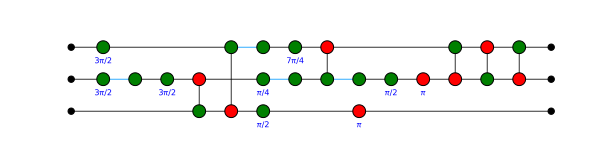

In [244]:
g = c1.to_graph()
zx.simplify.clifford_simp(g,quiet=True)
c2 = zx.extract.streaming_extract(g)
#c4 = c1.copy()
#c4.gates = list(reversed(c4.gates))
o = Optimizer(c1)
#o.minimize_czs = True
display(zx.draw(o.parse_forward()))
c3 = o.parse_circuit()
#display(zx.draw(c1))
zx.draw(c3)

In [245]:
zx.compare_tensors(c1,c3)

True

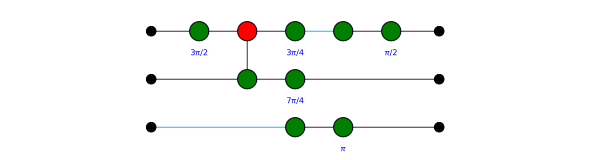

In [182]:
c3 = Optimizer(c3.to_basic_gates()).parse_circuit()
zx.draw(c3)